In [1]:
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt

from plotly import graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
from IPython.display import display, IFrame

In [2]:
def download_file_from_gdrive(file_url, filename, out_path, overwrite=False):
    file_exists = (out_path / filename).exists()
    
    if (file_exists and overwrite) or (not file_exists): 
        os.system(f'gdown {file_url} -O {out_path}/{filename}')

In [3]:
df = pd.read_csv('/home/hello/Documents/coding/ML/cancer_EDA_KR/dataset1/data - Kyrgyzstan3.csv')

In [5]:
df.head()

,Наименование показателей,total,мужчины,"[0]Губы, полости рта и глотки",[0]Желудка,[0]Прямой кишки,"[0]Трахеи, бронхов и легкого",[0]Кожи,[0]Лимфатической и кроветворной ткани,[0]Прочих органов,...,[1]Лимфатической и кроветворной ткани,[1]Прочих органов,Состоят на учете в леч.уч.,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,[1]Прочих органов.1,Состоят на учете в леч.уч..1
0,1990,5370,2679,118,495,69,577,313,167,940,...,121,1559,20100,NaN,NaN,NaN,NaN,NaN,"1,559","20,100"
1,1991,5209,2678,107,499,73,547,315,156,981,...,123,1537,20608,NaN,NaN,NaN,NaN,NaN,"1,537","20,608"
2,1992,4930,2615,119,511,83,550,240,136,976,...,110,1364,19726,NaN,NaN,NaN,NaN,NaN,"1,364","19,726"
3,1993,4562,2292,125,456,65,422,242,119,863,...,97,1397,19213,NaN,NaN,NaN,NaN,NaN,"1,397","19,213"
4,1994,4104,2124,113,436,59,395,218,121,782,...,88,1250,18384,NaN,NaN,NaN,NaN,NaN,"1,250","18,384"


In [6]:
df = df[['Наименование показателей', 'total']].dropna().drop_duplicates()

In [7]:
len(df)

32

In [8]:
df['date'] = df['Наименование показателей']
del df['Наименование показателей']

In [9]:
df['date'] = pd.to_datetime(df['date'], format='%Y')

In [10]:
df.sort_values(by=['date']).head(n=10)

,total,date
0,5370,1990-01-01
1,5209,1991-01-01
2,4930,1992-01-01
3,4562,1993-01-01
4,4104,1994-01-01
5,4235,1995-01-01
6,4211,1996-01-01
7,4341,1997-01-01
8,4782,1998-01-01
9,4629,1999-01-01


In [11]:
aggr_df = df.groupby('date')[['total']].mean()
aggr_df.columns = ['incidences']

In [12]:
aggr_df.head()

,incidences
date,
1990-01-01,5370.0
1991-01-01,5209.0
1992-01-01,4930.0
1993-01-01,4562.0
1994-01-01,4104.0


In [13]:
init_notebook_mode(connected=True)

In [14]:
def plotly_df(df, title='', width=800, height=500):
    common_kw = dict(x=df.index, mode='lines')
    data = [go.Scatter(y=df[c], name=c, **common_kw) for c in df.columns]
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    
    plot_path = f"home/hello/_static/plotly_htmls/{title}.html".replace(" ", "_")
    plot(fig, filename=plot_path, show_link=False, auto_open=False);
    display(IFrame(plot_path, width=width, height=height))

In [15]:
annual_df = aggr_df.resample('Y').apply(sum)
annual_df.head()

,incidences
date,
1990-12-31,5370.0
1991-12-31,5209.0
1992-12-31,4930.0
1993-12-31,4562.0
1994-12-31,4104.0


In [16]:
import logging

from prophet import Prophet

logging.getLogger().setLevel(logging.ERROR)

In [17]:

df.columns = ['y', 'ds']
df.tail(n=3)

,y,ds
29,5625,2019-01-01
30,5389,2020-01-01
31,5753,2021-01-01


In [18]:
prediction_size = 5
train_df = df
train_df.tail(n=3)

,y,ds
29,5625,2019-01-01
30,5389,2020-01-01
31,5753,2021-01-01


In [19]:
predict_model = Prophet()
predict_model.fit(train_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [20]:
future = predict_model.make_future_dataframe(periods=prediction_size, freq='Y')
future.tail(n=3)

,ds
34,2023-12-31
35,2024-12-31
36,2025-12-31


In [21]:
forecast = predict_model.predict(future)
forecast.tail(n=5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
32,2021-12-31,-1235.283809,4964.945352,5648.121564,-1238.015477,-1233.020271,6546.285133,6546.285133,6546.285133,6546.285133,6546.285133,6546.285133,0.0,0.0,0.0,5311.001323
33,2022-12-31,-1160.436542,4758.149200,5459.214704,-1169.191647,-1152.913409,6279.008758,6279.008758,6279.008758,6279.008758,6279.008758,6279.008758,0.0,0.0,0.0,5118.572215
34,2023-12-31,-1085.589275,4541.310514,5203.196525,-1102.081545,-1071.070024,5957.008246,5957.008246,5957.008246,5957.008246,5957.008246,5957.008246,0.0,0.0,0.0,4871.418971
35,2024-12-31,-1010.536947,5410.562823,6067.402840,-1035.919880,-987.475183,6758.404481,6758.404481,6758.404481,6758.404481,6758.404481,6758.404481,0.0,0.0,0.0,5747.867534
36,2025-12-31,-935.689680,5274.021995,5941.163657,-971.450837,-899.737074,6546.285133,6546.285133,6546.285133,6546.285133,6546.285133,6546.285133,0.0,0.0,0.0,5610.595453


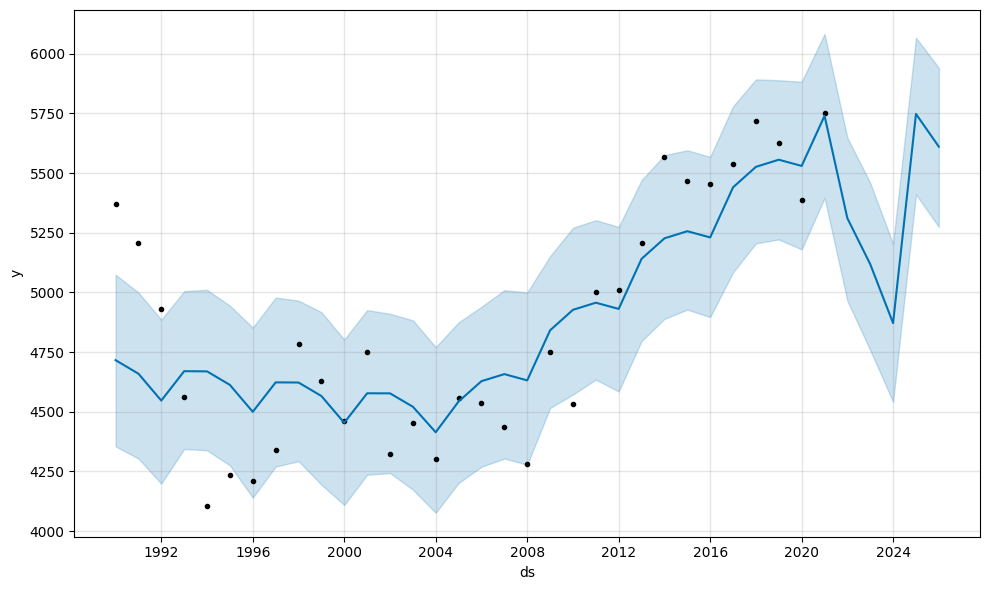

In [22]:
predict_model.plot(forecast);

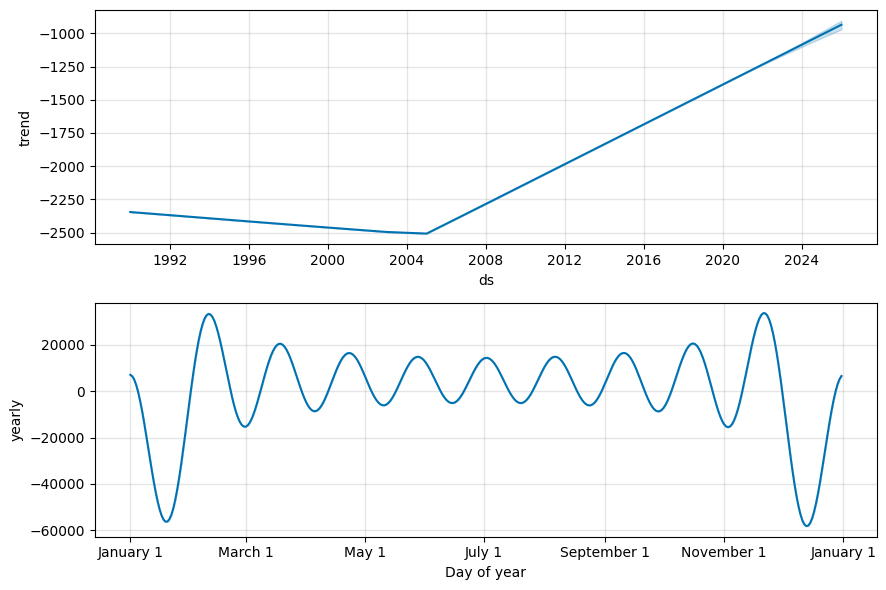

In [147]:
predict_model.plot_components(forecast);

In [122]:
print(", ".join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


In [23]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [24]:
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']

In [25]:
def show_forecast(cmp_df, num_predictions, num_values, title, width=800, height=500):
    """Visualize the forecast."""

    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode="lines")
        args.update(kwargs)
        return go.Scatter(**args)

    lower_bound = create_go(
        "Lower Bound",
        "yhat_lower",
        num_predictions,
        line=dict(width=0),
        marker=dict(color="gray"),
    )
    upper_bound = create_go(
        "Upper Bound",
        "yhat_upper",
        num_predictions,
        line=dict(width=0),
        marker=dict(color="gray"),
        fillcolor="rgba(68, 68, 68, 0.3)",
        fill="tonexty",
    )
    forecast = create_go(
        "Forecast", "yhat", num_predictions, line=dict(color="rgb(31, 119, 180)")
    )
    actual = create_go("Actual", "y", num_values, marker=dict(color="red"))

    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title="Incidences"), title=title, showlegend=False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)


show_forecast(cmp_df, prediction_size, 100, "New incidences")